## LRP

In [98]:
# Biblioteki

from PIL import Image
import torchvision.transforms as transforms
import torch

from zennit.rules import Epsilon
from zennit.composites import EpsilonPlusFlat, EpsilonAlpha2Beta1Flat, DeconvNet, GuidedBackprop, BetaSmooth, ExcitationBackprop
from zennit.attribution import Gradient

import matplotlib.pyplot as plt
import numpy as np

from util.cnn_parameters import IMG_HEIGHT, IMG_WIDTH, TEST_IMAGES_PATH
from util.torch_architecture import CNN

### Załadowanie modelu


In [99]:
model = CNN()
model.load_state_dict(torch.load("cats_dogs_cnn.pth", map_location=torch.device("cpu")))
model.eval()

C:\Users\magma\AppData\Local\Temp\ipykernel_24804\529079767.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cats_dogs_cnn.pth", map_loc

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=

### Image Preprocessing

In [100]:


transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Match training size
    transforms.ToTensor(),
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image.unsqueeze(0)  # Add batch dimension

def prepare_image(image_path):

    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
        transforms.ToTensor(),
    ])

    input_image = transform(image).unsqueeze(0)

    print("Input image shape:", input_image.shape)  # [1, 128, 128, 3]
    return input_image


image_path = TEST_IMAGES_PATH + "\\1.jpg"
input_image = prepare_image(image_path)



Input image shape: torch.Size([1, 3, 128, 128])


### LRP

In [101]:
# Metoda LRP
def LRP_method(pytorch_model, input_image):

    pytorch_model.eval()

    # LRP:
    composite = EpsilonPlusFlat(epsilon=1e-6)

    with Gradient(pytorch_model, composite=composite) as attributor:
        _, relevance = attributor(input_image)

    relevance = relevance.detach().cpu().numpy()

    print("Relevance shape:", relevance.shape)  # [1, 128, 128, 3]
    return relevance

def plot_lrp(image, heatmap):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    orig_image = image.squeeze().permute(1, 2, 0).numpy()
    axes[0].imshow(orig_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    heatmap_2d = np.sum(heatmap.squeeze(), axis=0)  #  (1,128,128,3) > (128,128)
    # heatmap_2d = (heatmap_2d - heatmap_2d.min()) / (heatmap_2d.max() - heatmap_2d.min())

    axes[1].imshow(heatmap_2d, cmap="seismic", interpolation="nearest")
    axes[1].set_title("LRP Heatmap")
    axes[1].axis("off")

    plt.show()

def plot_lrp_4_images(images, heatmaps):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    for i in range(4):
        row = i // 2   # 0 for first two images, 1 for last two
        col = (i % 2) * 2  # 0, 2 in row 0; 0, 2 in row 1

        # Original Image
        axes[row, col].imshow(images[i].squeeze().cpu().numpy())
        axes[row, col].set_title(f"Original Image {i+1}")
        axes[row, col].axis("off")

        # LRP Heatmap
        heatmap_2d = np.sum(heatmaps[i].squeeze(), axis=-1)  # Convert to 2D heatmap
        heatmap_2d = (heatmap_2d - heatmap_2d.min()) / (heatmap_2d.max() - heatmap_2d.min())  # Normalize

        axes[row, col + 1].imshow(heatmap_2d, cmap="seismic", interpolation="nearest")
        axes[row, col + 1].set_title(f"LRP Heatmap {i+1}")
        axes[row, col + 1].axis("off")

    plt.tight_layout()
    plt.show()




In [102]:

composites = [
    EpsilonPlusFlat(epsilon=1e-6),
    EpsilonAlpha2Beta1Flat(epsilon=1e-6),
    DeconvNet(),
    ExcitationBackprop(),
    GuidedBackprop(),
    BetaSmooth()
]

Input image shape: torch.Size([1, 3, 128, 128])
Relevance shape: (1, 3, 128, 128)


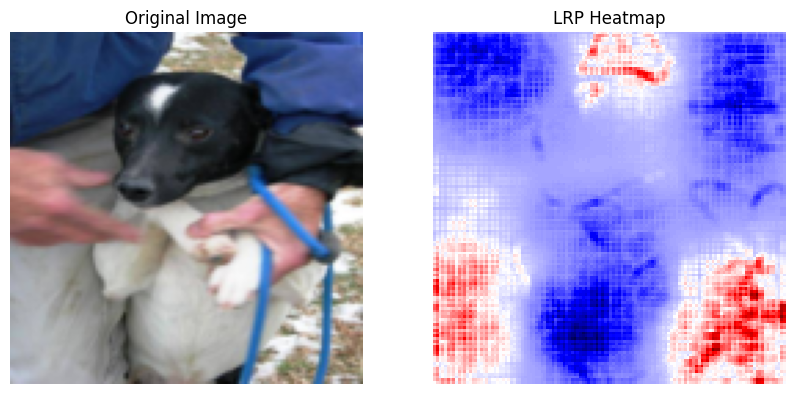

In [103]:
image_path = TEST_IMAGES_PATH + "\\1.jpg"
input_image = prepare_image(image_path)


relevance = LRP_method(model, input_image)

plot_lrp(input_image, relevance)